In [164]:
import mrcfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from copy import copy
from time import time

def load(path, pad=40):
    return mrcfile.mmap(path, mode='r').data[pad:-pad or None, pad:-pad or None, pad:-pad or None]

def save(save_path, data):
    with mrcfile.new(save_path, overwrite=True) as mrc:
        mrc.set_data(data)

def get_contrast(image, sigma=2):
    if sigma==None:
        return image.min(), image.max()
        
    mean = np.mean(image)
    std = np.std(image)
    
    lower_value = mean - sigma * std
    upper_value = mean + sigma * std
    return lower_value, upper_value

def auto_contrast(image, sigma=2):
    if sigma==None:
        return image
        
    lower_value, upper_value = get_contrast(image, sigma=sigma)

    return np.clip(image, lower_value, upper_value)

def split_volume(volume):
    if volume.shape[0] % 2 !=0:
        volume = volume[:-1]
    N = volume.shape[0]//2
    return volume[::2].flatten(), volume[1::2].flatten()

# def split_volume(volume):
#     shape = volume.shape
#     odd_index = list(np.arange(1, shape[i], 2) for i in range(len(shape)))
#     even_index = list(np.arange(0, shape[i], 2) for i in range(len(shape)))

#     vol1 = volume[even_index[0], :, :][:, odd_index[1], :][:, :, odd_index[2]] + \
#              volume[odd_index[0], :, :][:, odd_index[1], :][:, :, odd_index[2]]
#     vol2 = volume[even_index[0], :, :][:, even_index[1], :][:, :, even_index[2]] + \
#              volume[odd_index[0], :, :][:, even_index[1], :][:, :, even_index[2]]
#     return vol1.flatten(), vol2.flatten()

def get_snr(volume):
    volume = volume.astype('float')
    even, odd = split_volume(volume)
    # even = (even - np.mean(even)) / (np.std(even) * len(even))
    # odd = (odd - np.mean(odd)) / (np.std(odd) * len(odd))
    ccc = np.corrcoef(even, odd)[0,1]
    print(ccc)
    snr = 10*np.log10(ccc/(1-ccc))
    return snr

In [165]:
raw_1x_path = "/nfs/datasync4/inacio/data/raw_data/cryo/novareconstructions/cropped/rotacell_grid1_TS09_ctf_1xBin.rec"
raw_3x_path = "/nfs/datasync4/inacio/data/raw_data/cryo/novareconstructions/rotacell_grid1_TS09_ctf_3xBin.rec"
raw_6x_path = "/nfs/datasync4/inacio/data/raw_data/cryo/novareconstructions/rotacell_grid1_TS09_ctf_6xBin.rec"
cs_1x_path = "/nfs/datasync4/inacio/data/denoising/cryosamba/rotacell_grid1_TS09_ctf_1xBin/inference_prev/result.rec"
cs_3x_path = "/nfs/datasync4/inacio/data/denoising/cryosamba/rotacell_grid1_TS09_ctf_3xBin/inference/result.rec"
cs_6x_path = "/nfs/datasync4/inacio/data/denoising/cryosamba/rotacell_grid1_TS09_ctf_6xBin/inference_prev/result.rec"

tp_1x_path = "/nfs/datasync4/inacio/data/denoising/topaz/rotacell_grid1_TS09_ctf_1xBin.rec"
tp_3x_path = "/nfs/datasync4/inacio/data/denoising/topaz/rotacell_grid1_TS09_ctf_3xBin.rec"
tp_6x_path = "/nfs/datasync4/inacio/data/denoising/topaz/rotacell_grid1_TS09_ctf_6xBin.rec"
cc_1x_path = "/nfs/datasync4/inacio/data/denoising/cryocare/rota_1x/rotacell_grid1_TS09_ctf_1xBin.rec"
cc_3x_path = "/nfs/datasync4/inacio/data/denoising/cryocare/rota3x/rotacell_grid1_TS09_ctf_3xBin.rec"
cc_6x_path = "/nfs/datasync4/inacio/data/denoising/cryocare/rota6x/rotacell_grid1_TS09_ctf_6xBin.rec"

raw = [load(raw_6x_path), load(raw_3x_path), load(raw_1x_path)]
cs = [load(cs_6x_path), load(cs_3x_path), load(cs_1x_path)]
tp = [load(tp_6x_path), load(tp_3x_path), load(tp_1x_path)]
cc = [load(cc_6x_path), load(cc_3x_path), load(cc_1x_path)]

In [159]:
# Volume params

y, dy = 360 * 6, 250 * 6
x, dx = 340 * 6, 250 * 6

z6 = 238-64
z3 = 530-64*2
z1 = 100

Z = [z6, z3, z1]
Y = [y//6, y//3, 0]
X = [x//6, x//3, 0]

DZ = [64, 64*2, 400]
DY = [dy//6, dy//3, dy]
DX = [dx//6, dx//3, dx]

L = [3, 6, 10]

raw = [np.asarray(raw[i][Z[i]:Z[i]+DZ[i], Y[i]:Y[i]+DY[i], X[i]:X[i]+DX[i]]) for i in range(3)]
cs = [np.asarray(cs[i][Z[i]:Z[i]+DZ[i], Y[i]:Y[i]+DY[i], X[i]:X[i]+DX[i]]) for i in range(3)]
tp = [np.asarray(tp[i][Z[i]:Z[i]+DZ[i], Y[i]:Y[i]+DY[i], X[i]:X[i]+DX[i]]) for i in range(3)]
cc = [np.asarray(cc[i][Z[i]:Z[i]+DZ[i], Y[i]:Y[i]+DY[i], X[i]:X[i]+DX[i]]) for i in range(3)]

In [166]:
start = time()

i = 2
snr_raw = get_snr(raw[i])
snr_cs = get_snr(cs[i])
snr_tp = get_snr(tp[i])
snr_cc = get_snr(cc[i])

print(time()-start)

0.43853373124358724
0.8461868069223812
0.8849686103085151
0.40194828549163025
22.71247386932373


In [167]:
print(snr_raw, snr_cs, snr_tp, snr_cc)

-1.0732066609002382 7.4047266190171515 8.86111500092607 -1.7256855924385819


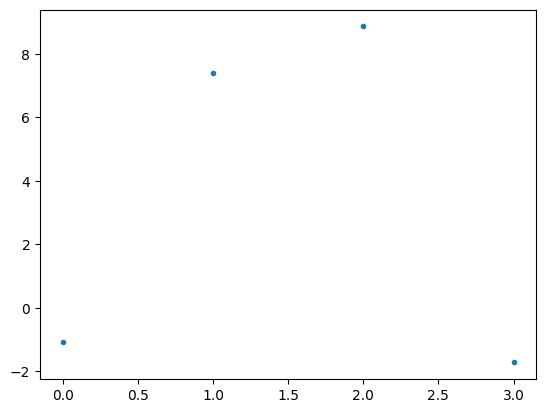

In [168]:
plt.plot([snr_raw, snr_cs, snr_tp, snr_cc], '.')
plt.show()